In [248]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.layers import Embedding
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [249]:
TRAIN_DIRECTORY = "big-files/train/"
TEST_DIRECTORY = "big-files/test/"
GLOVE_DIRECTORY = "big-files/glove.6B/"
MAX_WORDS = 10000
MAX_LEN = 100 # Отсечение остатка отзывов после 100-го слова
EPOCHS = 15
BATCH_SIZE = 32

In [250]:
txt = ["Hello my little world", "My name is Ivan Zdravkov", "Now i live in Bulgaria, republic of"]

In [251]:
# Создание и обучение токенизатора
tokenizer = Tokenizer()
tokenizer.fit_on_texts(txt)

In [252]:
# Преобразование текстов в числовые последовательности
sequence = tokenizer.texts_to_sequences(txt)

In [253]:
# Создание one-hot матрицы
one_hot_result = tokenizer.texts_to_matrix(txt)

In [254]:
# Получение словаря
word_index = tokenizer.word_index

In [255]:
one_hot_result

array([[0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.]])

# Загрузка данных из IMDB в виде простого текста
# ТОКЕНИЗАЦИЯ

In [256]:
texts = []
labels = []
for label_type in ["neg", "pos"]:
    dir_name = os.path.join(TRAIN_DIRECTORY, label_type)
    
    for fname in os.listdir(dir_name):
        if fname.endswith(".txt"):
            with open(os.path.join(dir_name, fname), "r", encoding="utf-8") as f: 
                # Использование контекстного менеджера with: Это гарантирует, что файлы будут закрыты автоматически после завершения работы с ними, даже если произойдет ошибка.
                # Явное указание кодировки utf-8: Это помогает избежать проблем с кодировками, которые могут возникнуть при чтении текстовых файлов.
                texts.append(f.read())
                
            if label_type == "neg":
                labels.append(0)
            else:
                labels.append(1)

In [257]:
df = pd.DataFrame({"text": texts, "labels": labels}).replace({0: "neg", 1: "pos"})
df

,text,labels
0,Story of a man who has unnatural feelings for ...,neg
1,Airport '77 starts as a brand new luxury 747 p...,neg
2,This film lacked something I couldn't put my f...,neg
3,"Sorry everyone,,, I know this is supposed to b...",neg
4,When I was little my parents took me along to ...,neg
...,...,...
24995,"Seeing as the vote average was pretty low, and...",pos
24996,"The plot had some wretched, unbelievable twist...",pos
24997,I am amazed at how this movie(and most others ...,pos
24998,A Christmas Together actually came before my t...,pos


In [258]:
# Создание и обучение токенизатора
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(texts)

In [259]:
# Преобразование текстов в числовые последовательности
sequence = tokenizer.texts_to_sequences(texts)

In [260]:
word_index = tokenizer.word_index

In [261]:
data = pad_sequences(sequence, maxlen=MAX_LEN)

In [262]:
labels = np.asarray(labels).astype("float32")

In [263]:
print(data.shape, labels.shape)

(25000, 100) (25000,)


In [264]:
# Разбиваем данные на обучающую и промежуточную выборки
x_train, x_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, shuffle=True)

# Разбиваем промежуточную выборку на проверочную и тестовую выборки
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.4, shuffle=True)
len(x_train)

17500

In [265]:
len(x_train)

17500

In [266]:
model = Sequential([
    Embedding(10000, 8),
    Flatten(),
    Dropout(0.4),
    Dense(16, activation="relu"), # Функция relu (rectified linear unit — блок линейной ректификации) используется для преобразования отрицательных значений в ноль
    Dropout(0.4),
    Dense(1, activation="sigmoid"), # сигмоидная функция рассредоточивает произвольные значения по интервалу [0, 1]
])

In [267]:
model.compile(optimizer="adam", 
              loss="binary_crossentropy",
              metrics=["acc"])

In [268]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.4, 
                                            min_lr=0.00001)


early_stopping = EarlyStopping(patience = 5)
    
callbacks = [early_stopping, learning_rate_reduction]

In [269]:
history = model.fit(x_train, 
                    y_train, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_data=(x_val, y_val),
                    callbacks=callbacks)

Epoch 1/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - acc: 0.5355 - loss: 0.6796 - val_acc: 0.8324 - val_loss: 0.3930 - learning_rate: 0.0010
Epoch 2/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - acc: 0.8516 - loss: 0.3648 - val_acc: 0.8584 - val_loss: 0.3299 - learning_rate: 0.0010
Epoch 3/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - acc: 0.8968 - loss: 0.2664 - val_acc: 0.8620 - val_loss: 0.3265 - learning_rate: 0.0010
Epoch 4/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - acc: 0.9331 - loss: 0.1964 - val_acc: 0.8551 - val_loss: 0.3574 - learning_rate: 0.0010
Epoch 5/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - acc: 0.9510 - loss: 0.1478 - val_acc: 0.8471 - val_loss: 0.3852 - learning_rate: 0.0010
Epoch 6/15
533/547 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.9536 - loss: 0.1312
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - acc: 0.9535 - loss: 0.1313 - val_acc: 0.8462 - val_loss: 0.4182 - learning_rate: 0.0010
Ep

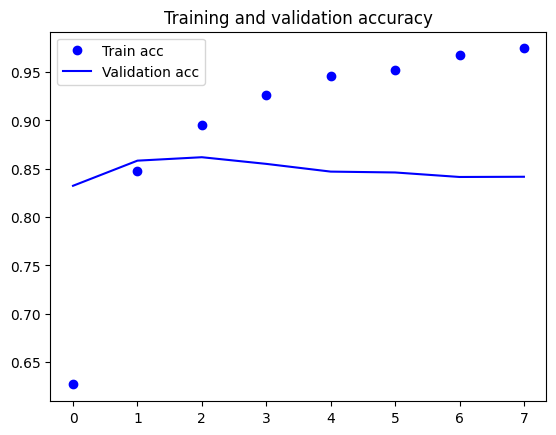

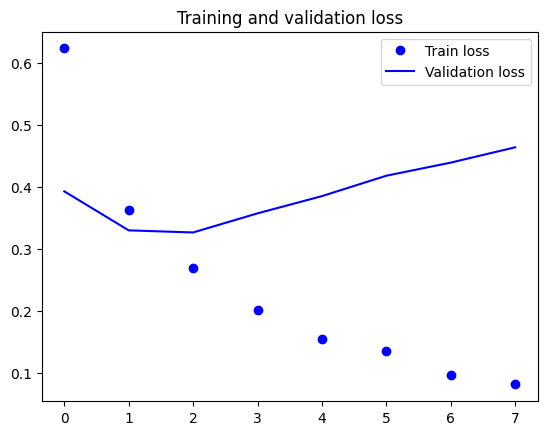

In [270]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure()
plt.plot(acc, 'bo', label='Train acc')
plt.plot(val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(loss, 'bo', label='Train loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [271]:
pred = model.predict(x_test)
pred

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step


array([[0.9960496 ],
       [0.63472795],
       [0.9903161 ],
       ...,
       [0.98325723],
       [0.0042543 ],
       [0.27920997]], dtype=float32)

In [272]:
pred_labels = (pred > 0.5).astype(int)

In [273]:
# Загрузка словаря
word_index = imdb.get_word_index()
reverse_word_index = {value: key for key, value in word_index.items()}

# Преобразование числовых последовательностей в текст
decoded_reviews = []
for seq in x_test:
    decoded_review = ' '.join([reverse_word_index.get(i - 3, '***') for i in seq])
    decoded_reviews.append(decoded_review)


In [274]:
# Создание DataFrame для всех данных
results = pd.DataFrame({
    'Review': decoded_reviews,
    'True Label': y_test,
    'Predicted Probability': pred.flatten(),
    'Predicted Label': pred_labels.flatten()
})

pd.DataFrame(results)

,Review,True Label,Predicted Probability,Predicted Label
0,watching you're par a get insist one ford *** ...,1.0,0.996050,1
1,*** *** *** *** *** *** *** *** *** *** *** **...,1.0,0.634728,1
2,whose they *** look now wonder *** *** have ha...,1.0,0.990316,1
3,*** *** *** *** *** *** *** *** *** *** *** **...,1.0,0.999842,1
4,than *** be not late through but worst own rea...,1.0,0.189481,0
...,...,...,...,...
2995,*** 100 chase *** rather manga *** premise was...,0.0,0.996324,1
2996,but to *** wow truth to *** would definitely m...,0.0,0.001436,0
2997,kidnapped follows *** europa where first and h...,1.0,0.983257,1
2998,due like *** laugh outfit chemistry with even ...,0.0,0.004254,0


In [275]:
embeddings_index = {}

with open(os.path.join(GLOVE_DIRECTORY, 'glove.6B.100d.txt'), encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs


In [276]:
# Шаг 2: Создание эмбеддинговой матрицы
def create_embedding_matrix(word_index, embeddings_index, embedding_dim):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [277]:
embedding_dim = 100
embedding_matrix = create_embedding_matrix(word_index, embeddings_index, embedding_dim)

In [278]:
new_model = Sequential([
    Embedding(input_dim=len(word_index) + 1,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=MAX_LEN,
              trainable = False), # Максимальная длина входной последовательности
    
    LSTM(32),
    Dense(16, activation="relu"), # Функция relu (rectified linear unit — блок линейной ректификации) используется для преобразования отрицательных значений в ноль
    Dropout(0.4),
    Dense(1, activation="sigmoid"), # сигмоидная функция рассредоточивает произвольные значения по интервалу [0, 1]
])

c:\Users\ivanz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [279]:
new_model.compile(optimizer="adam", 
              loss="binary_crossentropy",
              metrics=["acc"])

In [280]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.4, 
                                            min_lr=0.00001)


early_stopping = EarlyStopping(patience = 5)
    
callbacks = [early_stopping, learning_rate_reduction]

In [281]:
history = new_model.fit(x_train, 
                    y_train, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_data=(x_val, y_val),
                    callbacks=callbacks)

Epoch 1/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - acc: 0.5556 - loss: 0.6805 - val_acc: 0.6587 - val_loss: 0.6102 - learning_rate: 0.0010
Epoch 2/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - acc: 0.7057 - loss: 0.5798 - val_acc: 0.7396 - val_loss: 0.5126 - learning_rate: 0.0010
Epoch 3/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - acc: 0.7468 - loss: 0.5235 - val_acc: 0.7653 - val_loss: 0.4921 - learning_rate: 0.0010
Epoch 4/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - acc: 0.7576 - loss: 0.4961 - val_acc: 0.7780 - val_loss: 0.4615 - learning_rate: 0.0010
Epoch 5/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - acc: 0.7749 - loss: 0.4704 - val_acc: 0.7898 - val_loss: 0.4340 - learning_rate: 0.0010
Epoch 6/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - acc: 0.7995 - loss: 0.4379 - val_acc: 0.8000 - val_loss: 0.4264 - learning_rate: 0.0010
Epoch 7/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - acc: 0.8056 - loss: 0.4178 - val_acc: 0.7867 - val_loss: 0.4355 - learning_rate: 0.001

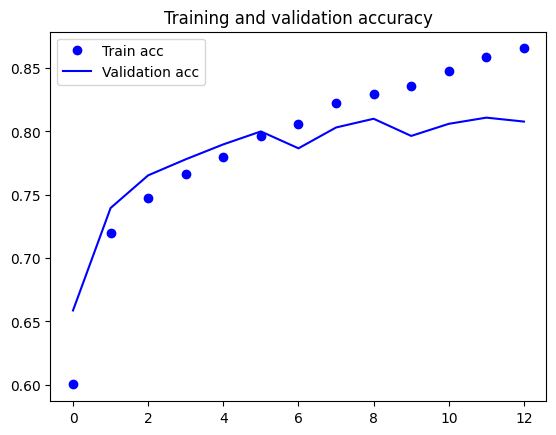

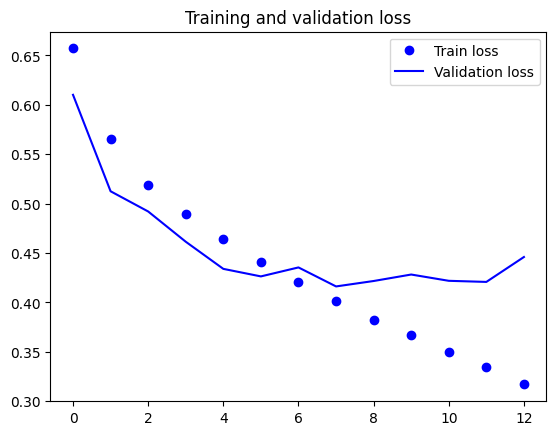

In [282]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure()
plt.plot(acc, 'bo', label='Train acc')
plt.plot(val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(loss, 'bo', label='Train loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()